In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [38]:
#Read the csv file
df=pd.read_csv('merged_data.csv')

In [39]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['mkt_datetime'])
print(train_dates.tail(15)) #Check last few dates. 

23553   2022-09-08 09:00:00
23554   2022-09-08 10:00:00
23555   2022-09-08 11:00:00
23556   2022-09-08 12:00:00
23557   2022-09-08 13:00:00
23558   2022-09-08 14:00:00
23559   2022-09-08 15:00:00
23560   2022-09-08 16:00:00
23561   2022-09-08 17:00:00
23562   2022-09-08 18:00:00
23563   2022-09-08 19:00:00
23564   2022-09-08 20:00:00
23565   2022-09-08 21:00:00
23566   2022-09-08 22:00:00
23567   2022-09-08 23:00:00
Name: mkt_datetime, dtype: datetime64[ns]


In [40]:
#Variables for training
cols = list(df)[1:12]
#Date and volume columns are not used in training. 
print(cols)

['int_nuc_sch', 'int_gas_sch', 'int_hyd_sch', 'int_win_sch', 'imp_mic_sch', 'imp_new_sch', 'imp_que_sch', 'ont_avg_dem', 'exp_mic_sch', 'exp_new_sch', 'exp_que_sch']


In [41]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [42]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [43]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 24  # Number of past days we want to use to predict the future.


In [44]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

In [45]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (23544, 24, 11).
trainY shape == (23544, 1).


In [46]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            19456     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,905
Trainable params: 31,905
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1325/1325 [==============================] - 35s 24ms/step - loss: 0.2709 - val_loss: 0.1357
Epoch 2/10
1325/1325 [==============================] - 31s 24ms/step - loss: 0.1499 - val_loss: 0.1314
Epoch 3/10
1325/1325 [==============================] - 39s 29ms/step - loss: 0.1357 - val_loss: 0.1123
Epoch 4/10
1325/1325 [==============================] - 35s 26ms/step - loss: 0.1351 - val_loss: 0.1059
Epoch 5/10
1325/1325 [==============================] - 42s 31ms/step - loss: 0.1300 - val_loss: 0.0895
Epoch 6/10
1325/1325 [==============================] - 40s 30ms/step - loss: 0.1291 - val_loss: 0.1001
Epoch 7/10
1325/1325 [==============================] - 40s 30ms/step - loss: 0.1242 - val_loss: 0.0957
Epoch 8/10
1325/1325 [==============================] - 33s 25ms/step - loss: 0.1216 - val_loss: 0.1063
Epoch 9/10
1325/1325 [==============================] - 34s 26ms/step - loss: 0.1205 - val_loss: 0.0940
Epoch 10/10
1325/1325 [==============================] - 33s 25m

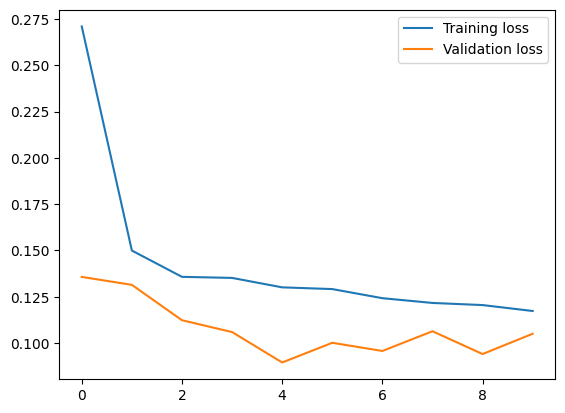

In [47]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [48]:
#Predicting...
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='H').tolist()
print(predict_period_dates)


[Timestamp('2022-09-08 08:00:00', freq='H'), Timestamp('2022-09-08 09:00:00', freq='H'), Timestamp('2022-09-08 10:00:00', freq='H'), Timestamp('2022-09-08 11:00:00', freq='H'), Timestamp('2022-09-08 12:00:00', freq='H'), Timestamp('2022-09-08 13:00:00', freq='H'), Timestamp('2022-09-08 14:00:00', freq='H'), Timestamp('2022-09-08 15:00:00', freq='H'), Timestamp('2022-09-08 16:00:00', freq='H'), Timestamp('2022-09-08 17:00:00', freq='H'), Timestamp('2022-09-08 18:00:00', freq='H'), Timestamp('2022-09-08 19:00:00', freq='H'), Timestamp('2022-09-08 20:00:00', freq='H'), Timestamp('2022-09-08 21:00:00', freq='H'), Timestamp('2022-09-08 22:00:00', freq='H')]


In [49]:
prediction = model.predict(trainX[-n_days_for_prediction:])

1/1 [==============================] - 0s 333ms/step


In [50]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [51]:
df_forecast = pd.DataFrame({'mkt_datetime':np.array(predict_period_dates), 'ont_ene':y_pred_future})
df_forecast['mkt_datetime']=pd.to_datetime(df_forecast['mkt_datetime'])

In [52]:
original = df[['mkt_datetime', 'ont_ene']]
original['mkt_datetime']=pd.to_datetime(original['mkt_datetime'])
original = original.loc[original['mkt_datetime'] >= '2022-09-08 08:00:00']


/tmp/ipykernel_16838/15949742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['mkt_datetime']=pd.to_datetime(original['mkt_datetime'])


<AxesSubplot:xlabel='mkt_datetime', ylabel='ont_ene'>

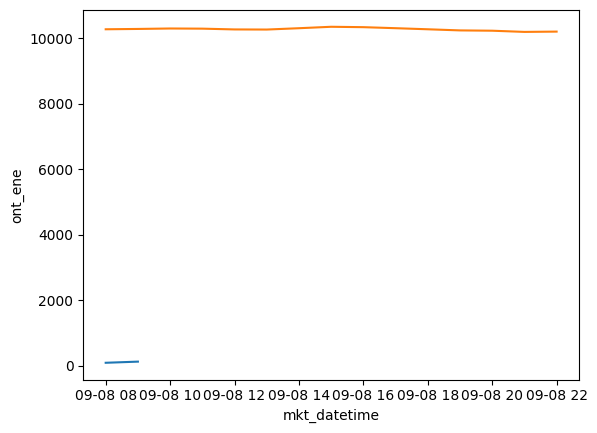

In [53]:
sns.lineplot(x=original['mkt_datetime'], y=original['ont_ene'])
sns.lineplot(x=df_forecast['mkt_datetime'],y= df_forecast['ont_ene'])

In [55]:
print(df_forecast)

          mkt_datetime       ont_ene
0  2022-09-08 08:00:00  10277.056641
1  2022-09-08 09:00:00  10286.958984
2  2022-09-08 10:00:00  10300.747070
3  2022-09-08 11:00:00  10295.921875
4  2022-09-08 12:00:00  10272.201172
5  2022-09-08 13:00:00  10268.617188
6  2022-09-08 14:00:00  10309.343750
7  2022-09-08 15:00:00  10353.108398
8  2022-09-08 16:00:00  10341.284180
9  2022-09-08 17:00:00  10309.990234
10 2022-09-08 18:00:00  10276.834961
11 2022-09-08 19:00:00  10242.470703
12 2022-09-08 20:00:00  10233.072266
13 2022-09-08 21:00:00  10196.672852
14 2022-09-08 22:00:00  10205.961914
